In [ ]:
import os 

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import plotly.io as pio
import datetime
import datajoint 
import seaborn as sns
import pandas as pd

In [ ]:
from workflow.pipeline import culture, ephys, mua, analysis

[2025-06-29 13:37:38,391][INFO]: Connecting judewerth@db.datajoint.com:3306
[2025-06-29 13:37:39,440][INFO]: Connected judewerth@db.datajoint.com:3306


Copying "Function neuronal circuitry and oscillatory dynamics in human brain organoids" population activity methods
- Procedure
    - Get population spike vector
        - pool spike times across all electrodes
        - create firing rate vector with 1 ms bins
        - apply 20 ms average window filter
        - apply 100 ms gausian kernal filter
    - Find bursts
        - threshold at 2x population spike vector rms value
        - extract peak amplitude, peak time, peak window (period which is 90% of peak)
- Current problems
    - MUA spike detection refractory period. Ours is 2 ms which doesn't really make sense for multiunit spikes. 


In [ ]:
def get_num_elec_inside(organoid_id: str):

    elec_inside = {
        "O09": 32, "O10": 16, "O11": 20, "O12": 14,
        "O13": 25, "O14": 13, "O15": 11, "O16": 11,
        "O17": 22, "O18": 19, "O19": 20, "O20": 17,
        "O21": 18, "O22": 21, "O23": 22, "O24": 23,
        "O25": 20, "O26": 32, "O27": 26, "O28": 24,
            }
    return elec_inside[organoid_id]

# Get spike times 
def get_spike_times(start_times, spike_indices):

    fs = 20000

    spike_times_us = np.array([], dtype='datetime64[us]')
    for start_time in np.unique(start_times):
        time_bool = start_times == start_time

        # extract spike data for start time
        time_data = spike_indices[time_bool] # uneven 2D array of spike indices
        spike_list = [spike_idx for chan_data in time_data for spike_idx in chan_data] # flatten to list 
        spike_times = np.array([np.datetime64(start_time) + np.timedelta64(np.int64(spike_idx/fs*1e6), 'us') for spike_idx in spike_list], dtype='datetime64[us]') # spike_idx -> datetime (us)

        spike_times_us = np.concatenate([spike_times_us, spike_times])
    print(f"            {len(spike_times_us)} spikes found in {len(np.unique(start_times))} minutes of recording")

    return(spike_times_us)

from scipy.ndimage import gaussian_filter1d

# process spike times
def get_population_firing_rate(start_times, spike_times_us):

    # determine window sizes
    ws_boxcar = 20 # ms
    ws_gaussian = 100 # ms

    spike_times_ms = spike_times_us.astype("datetime64[ms]") # convert us -> ms 
    recording_timeline = np.arange(np.min(start_times), np.max(start_times)+datetime.timedelta(minutes=1), np.timedelta64(1, 'ms'), dtype='datetime64[ms]')
    rel_spikes_ms = ((spike_times_ms - np.min(start_times.astype("datetime64[ms]"))) / np.timedelta64(1, 'ms')).astype(int) # int array of # of ms since experiment start time (per spike detected)

    # calculate firing rate vector (1 ms bins)
    firing_rate1 = np.zeros(recording_timeline.shape) # total number of ms from experiment start time -> end of final file

    for spike in rel_spikes_ms:
        firing_rate1[spike] += 1 # for each spike index add 1 
    firing_rate1 = firing_rate1 / 1e-3 # num spikes -> firing rate

    # apply boxcar filter
    boxcar_kernel = np.ones(ws_boxcar) / ws_boxcar
    firing_rate2 = np.convolve(firing_rate1, boxcar_kernel, mode="same")

    # apply gausian filter
    sigma = ws_gaussian / (2 * np.sqrt(2 * np.log(2))) 
    firing_rate3 = gaussian_filter1d(firing_rate2, sigma=sigma, mode="reflect")

    return firing_rate3, recording_timeline

# find burst amplitude, times, and windows
from scipy.signal import find_peaks

def get_burst_info(population_firing_vector, thresh):
    # find peaks parameters (in paper)
    threshold = thresh * np.std(population_firing_vector)
    distance = 1 * fs 

    # find times and amplitudes
    indexes, properties = find_peaks(population_firing_vector, height=threshold, distance=distance)
    amplitudes = properties['peak_heights']

    # find windows
    windows = []
    for index in indexes:
        wthresh = population_firing_vector[index] * .9 # 90% of peak

        w_start = 0
        w_end = 0

        i = 1
        while population_firing_vector[index-i] >= wthresh:
            w_start += 1
            i += 1
        
        i = 1
        while population_firing_vector[index+i] >= wthresh:
            w_end += 1
            i += 1
        
        windows.append([w_start, w_end])
    windows = np.array(windows) # samples from peak within 90%

    return indexes, amplitudes, windows

# Burst traces (segment at [-100, 350]ms windows)
from scipy import stats

def get_burst_waveforms(indexes, population_firing_vector, t_endpoints):
    ts, te = t_endpoints
    
    indexes2 = indexes[(ts <= indexes) & (indexes <= (len(recording_timeline)-te))] # remove bursts too close to the boundary

    # get burst traces
    burst_array = np.zeros((len(indexes2), int((ts+te))))
    for i, index in enumerate(indexes2):
        burst_array[i, :] = population_firing_vector[index-int(ts) : index+int(te)]

    burst_array = burst_array/1e3 # Hz -> kHz
    sem_vector = stats.sem(burst_array, axis=0)

    return indexes2, burst_array, sem_vector

def get_window_data(burst_array, t_endpoints, w_endpoints):
    ts, te = t_endpoints
    ws, we = w_endpoints

    window_data = burst_array[:, int(ts-ws) : -int(te-we)] # data within window

    return window_data

# Difference matrix (between bursts)

def get_diff_matrix(window_data):
    num_bursts = window_data.shape[0]

    diff_matrix = np.zeros((num_bursts, num_bursts))
    for i in range(num_bursts):
        for j in range(num_bursts):

            if i <= j:
                diff_matrix[i,j] = 0
            else:
                diff_matrix[i,j] = np.mean(np.abs(window_data[i,:] - window_data[j,:]))
    
    return diff_matrix

# Get ISIs (inter-burst and inter-spike (within bursts)) -> IGNORE BOUNDARIES 
# ms time scale too small for ISI -> use us
def get_isi_ibi(start_times, spike_times_us, indexes, windows):
    # rel_spikes_us is in terms of ms but is a float instead of an int
    rel_spikes_us = ((spike_times_us - np.min(start_times.astype("datetime64[us]"))) / np.timedelta64(1, 'ms')).astype(float) # int array of # of ms since experiment start time (per spike detected)

    isi = np.array([]) # ms
    burst_window_array = []

    for index, window in zip(indexes, windows):

        burst_window = index + (window*[-1,1]) # find burst windows (-1 to make the start time go negative) (ms)
        
        # find ISIs
        inner_burst_spikes = np.sort(rel_spikes_us[(burst_window[0] <= rel_spikes_us) & (rel_spikes_us <= burst_window[1])])
        isi = np.concatenate([isi, np.diff(inner_burst_spikes)])

        # put burst windows in array (to find ibi)
        burst_window_array.append(burst_window)
    burst_window_array = np.array(burst_window_array)

    # find IBIs (s)
    ibi = (burst_window_array[1:, 1] - burst_window_array[:-1, 0]) / 1e3 # difference between end of burst (n) and start of burst (n+1) -> Ignore boundaries

    return isi, ibi

[2025-06-29 20:44:29,738][WARNING]: MySQL server has gone away. Reconnecting to the server.


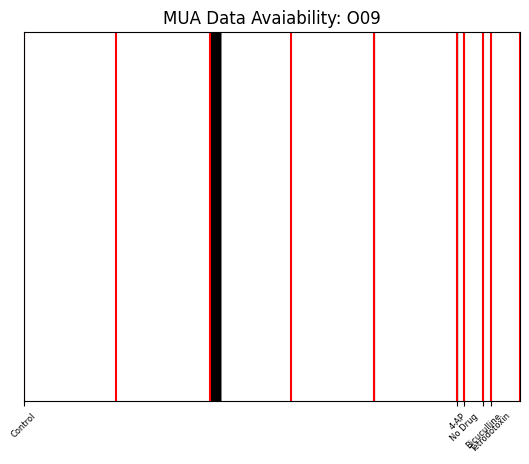

In [ ]:
# Determine session times -> between media changes

organoid_id = "O09"

# visualize recording timeline
drug_names, experiment_start_times, experiment_end_times = np.array((culture.Experiment & f"organoid_id = '{organoid_id}'").fetch("drug_name", "experiment_start_time", "experiment_end_time"))
start_times = np.unique((mua.MUASpikes.Channel & f"organoid_id = '{organoid_id}'").fetch("start_time")).astype('datetime64[m]')

recording_timeline = np.arange(np.min(experiment_start_times), np.max(experiment_end_times), np.timedelta64(1, 'm')).astype('datetime64[m]')

has_data = np.isin(recording_timeline, start_times)
drug_times = np.where(np.isin(recording_timeline, experiment_start_times))[0]

plt.imshow(~has_data[np.newaxis, :], aspect="auto", cmap="binary")
plt.xticks(drug_times, drug_names, rotation=45, fontsize=6)
plt.yticks([])
plt.title(f"MUA Data Avaiability: {organoid_id}")

# determine window intervals
breaks_idx = np.where(~has_data)[0]
recording_breaks = np.concatenate([[0, 4500], breaks_idx[np.concatenate([[True], np.diff(breaks_idx) != 1])]])
for b in recording_breaks:
    plt.axvline(b, color="r")


In [ ]:
# Create session dict based on recording intervals
# (recording_timeline[recording_breaks] - recording_timeline[0]) / np.timedelta64(1, 'D') # (see which days the breaks fall on (split first interval in 2))
session_titles = ["Control (Days 1-3)", "Control (Days 3-6)", "Control (Days 6-9)", "Control (Days 9-12)", "Control (Days 12-15)", "4-AP (Day 15)", "No Drug (Overnight)", "Bicuculline (Day 16)", "Tetrodotoxin (Day 16)"]
session_dict = {}

for i in range(len(recording_breaks)-1):

    session_string = f" \
        organoid_id = 'O09' \
            AND channel_idx IN { tuple(range(get_num_elec_inside('O09'))) } \
                AND start_time >= '{recording_timeline[recording_breaks[i]]}' \
                    AND start_time < '{recording_timeline[recording_breaks[i+1]]}'"
    
    session_dict[session_titles[i]] = session_string
session_dict

{'Control (Days 1-3)': "         organoid_id = 'O09'             AND channel_idx IN (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31)                 AND start_time >= '2023-05-03T17:33'                     AND start_time < '2023-05-06T20:33'",
 'Control (Days 3-6)': "         organoid_id = 'O09'             AND channel_idx IN (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31)                 AND start_time >= '2023-05-06T20:33'                     AND start_time < '2023-05-10T01:59'",
 'Control (Days 6-9)': "         organoid_id = 'O09'             AND channel_idx IN (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31)                 AND start_time >= '2023-05-10T01:59'                     AND start_time < '2023-05-12T19:55'",
 'Control (Days 9-12)': "         organoid_id = 'O09'     

In [ ]:
# Get Data

data_dict = {}
for title, restrictions in session_dict.items():
    print(f"starting analysis for {title}")

    print("     fetching data from query")
    start_times, spike_indices, spike_amplitudes = (mua.MUASpikes.Channel() & restrictions).fetch("start_time", "spike_indices", "spike_amp")
    spike_amplitudes = np.array([np.abs(spike_amp) for chan_data in spike_amplitudes for spike_amp in chan_data])

    # get spike times (array of np.datetime64[us])
    spike_times_us = get_spike_times(start_times=start_times, spike_indices=spike_indices)

    print("     calculating firing rate")
    # get population spike activity
    population_firing_vector, recording_timeline = get_population_firing_rate(start_times=start_times, spike_times_us=spike_times_us)

    print("     finding spike burst information")
    # extract spike burst information 
    thresh = 10 # threshold for identifying bursts (thresh * std())
    indexes, amplitudes, windows = get_burst_info(population_firing_vector=population_firing_vector, thresh=thresh)

    # get burst waveforms (to plot) / (removes bursts within t_endpoints of the boundary)
    t_endpoints = [1000, 1000] # ms before and after peak (to extract)
    indexes, burst_array, sem_vector = get_burst_waveforms(indexes=indexes, population_firing_vector=population_firing_vector, t_endpoints=t_endpoints) 

    # segment waveforms into smaller windows (for future analysis)
    w_endpoints = [250, 500]
    window_data = get_window_data(burst_array=burst_array, t_endpoints=t_endpoints, w_endpoints=w_endpoints)
    
    # get matrix with the average difference between each burst (to plot)
    diff_matrix = get_diff_matrix(window_data=window_data)

    # get ISI and IBI
    isi, ibi = get_isi_ibi(start_times=start_times, spike_times_us=spike_times_us, indexes=indexes, windows=windows)

    # extract data
    data_dict[title] = {
        "burst amplitudes": amplitudes,
        "burst waveform array": burst_array,
        "SEM vector": sem_vector,
        "burst difference matrix": diff_matrix,
        "ISI": isi,
        "IBI": ibi,
        "spike amplitudes": spike_amplitudes
    }




[2025-06-29 18:08:18,045][WARNING]: MySQL server has gone away. Reconnecting to the server.


starting analysis for Control (Days 1-3)
     fetching data from query
            49651 spikes found in 4500 minutes of recording
     calculating firing rate
     finding spike burst information
starting analysis for Control (Days 3-6)
     fetching data from query
            381320 spikes found in 4646 minutes of recording
     calculating firing rate
     finding spike burst information
starting analysis for Control (Days 6-9)
     fetching data from query
            355995 spikes found in 3417 minutes of recording
     calculating firing rate
     finding spike burst information
starting analysis for Control (Days 9-12)
     fetching data from query
            350146 spikes found in 4098 minutes of recording
     calculating firing rate
     finding spike burst information
starting analysis for Control (Days 12-15)
     fetching data from query
            11597 spikes found in 4070 minutes of recording
     calculating firing rate
     finding spike burst information
starting 

Generate Plots
- Intra-Sesson Analysis
    -  Visualize Burst waveforms and extracted windows
    - Visulatize the difference in bursts within an experiment
- Inter-Session Analysis
    - Compare ISI, IBI, burst amplitude between sessions

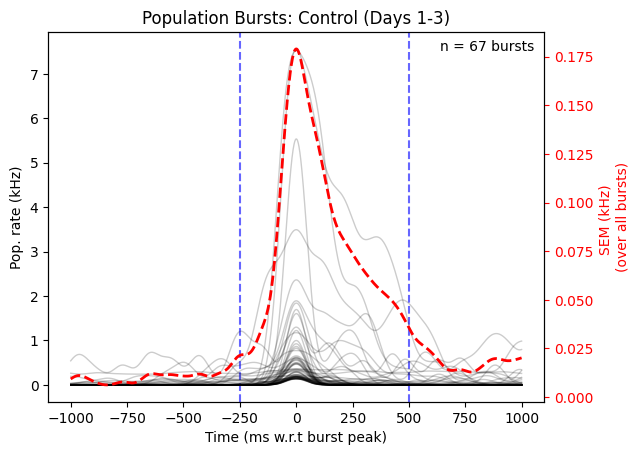

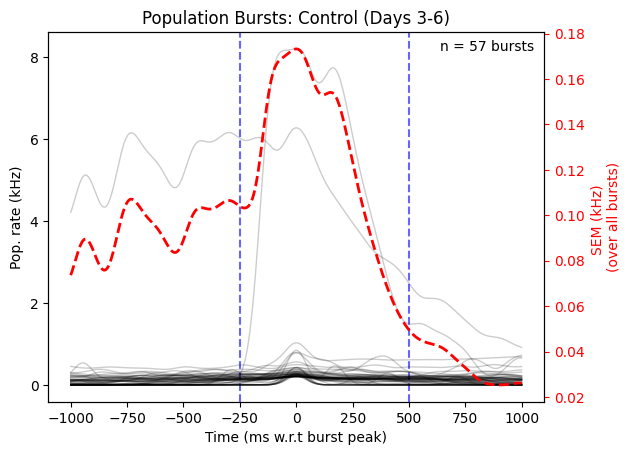

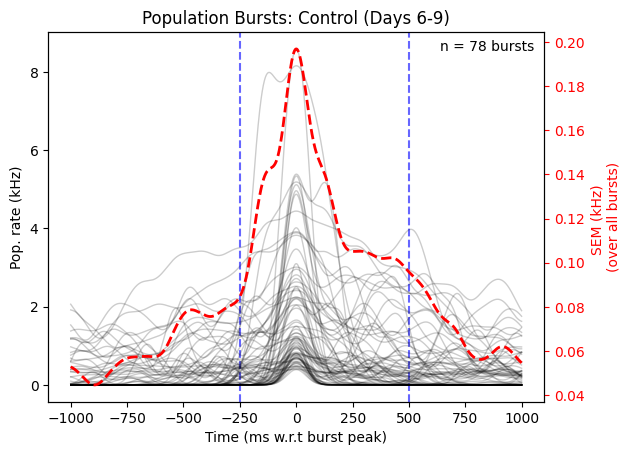

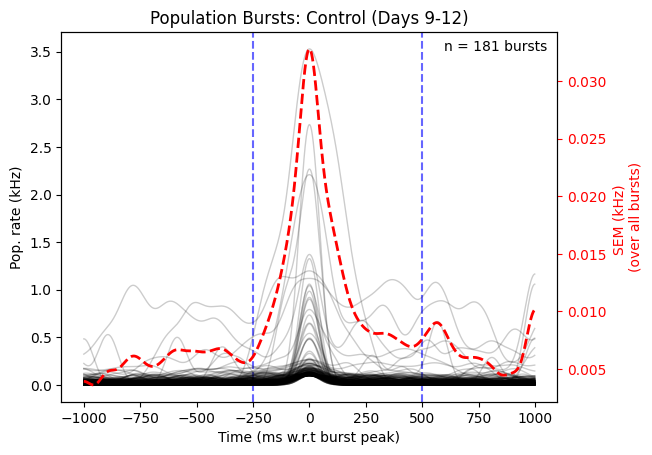

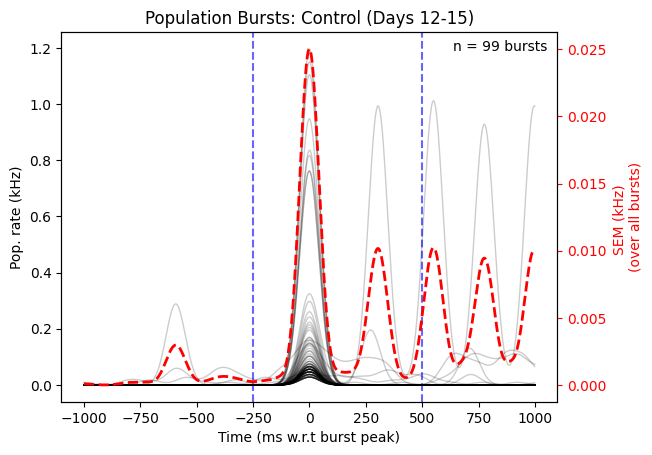

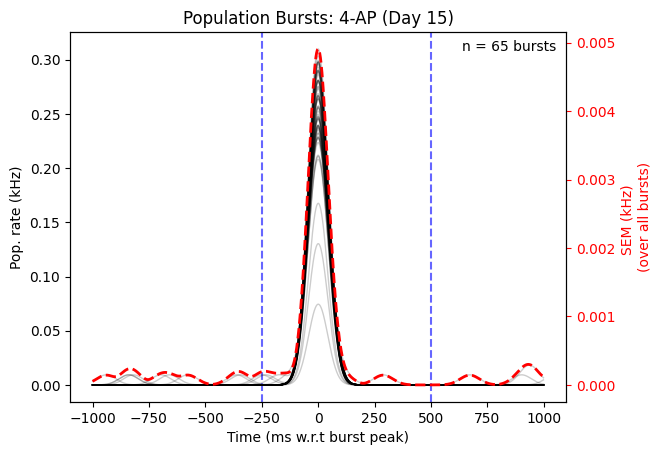

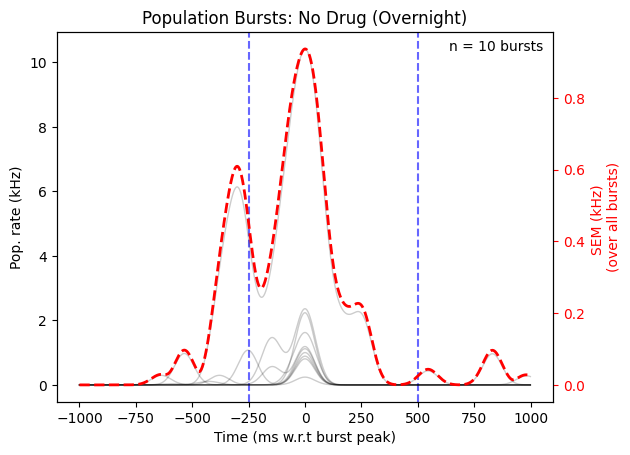

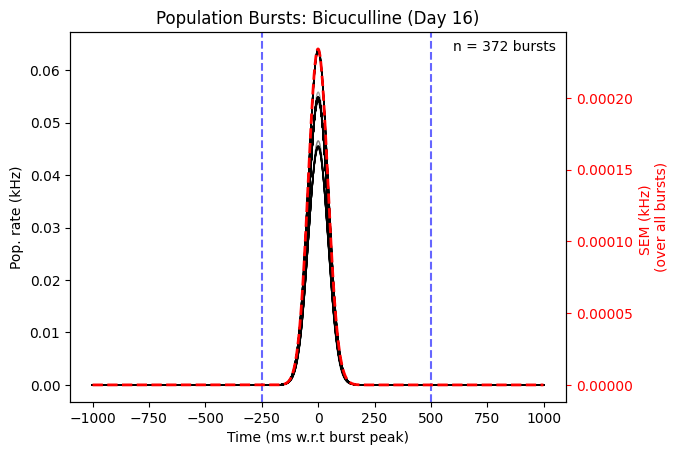

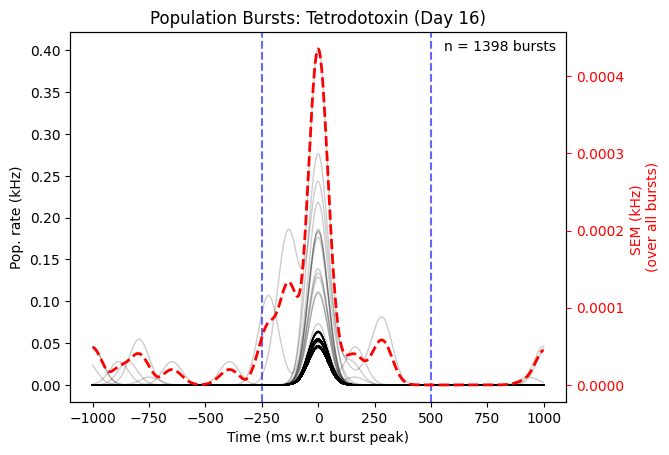

In [ ]:
# Plot burst waveforms

t = np.arange(-t_endpoints[0], t_endpoints[1])

for title, data in data_dict.items():
    fig, ax1 = plt.subplots()
    burst_array = data["burst waveform array"]
    sem_vector = data["SEM vector"]

    ax1.axvline(x=-w_endpoints[0], color='b', linestyle='--', alpha=.6)
    ax1.axvline(x=w_endpoints[1], color='b', linestyle='--', alpha=.6)

    ax1.text(0.98, 0.98, f"n = {burst_array.shape[0]} bursts",
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax1.transAxes)
    ax1.set_xlabel("Time (ms w.r.t burst peak)")
    ax1.set_title(f"Population Bursts: {title}")

    ax1.plot(t, burst_array.transpose(), color='k', alpha=.2, linewidth=1)
    ax1.set_ylabel("Pop. rate (kHz)", color='k')
    
    ax2 = ax1.twinx() 
    ax2.plot(t, sem_vector, color='r', linestyle='--', alpha=1, linewidth=2)
    ax2.set_ylabel("SEM (kHz) \n(over all bursts)", color='r')
    ax2.tick_params(axis='y', color='r', labelcolor='r')


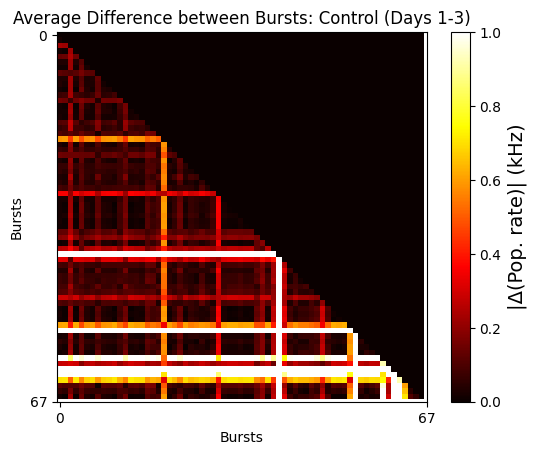

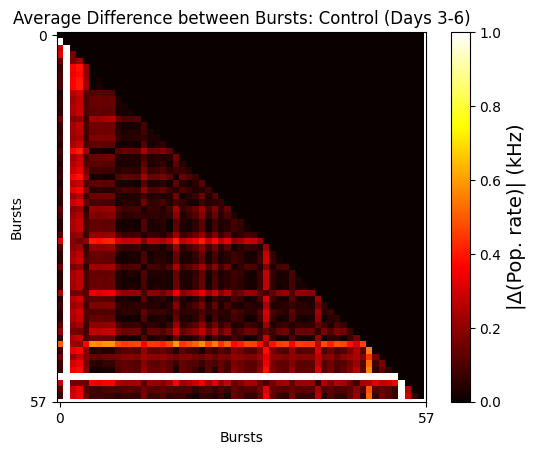

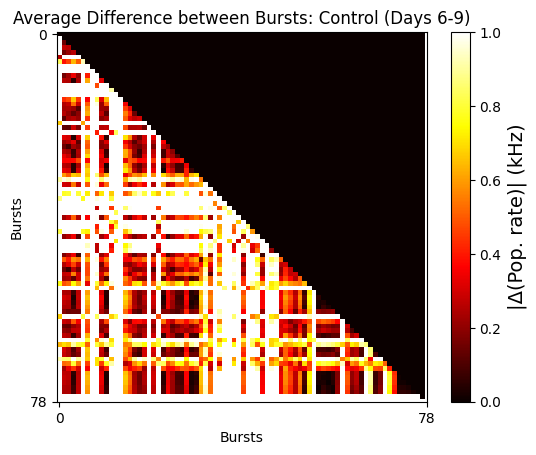

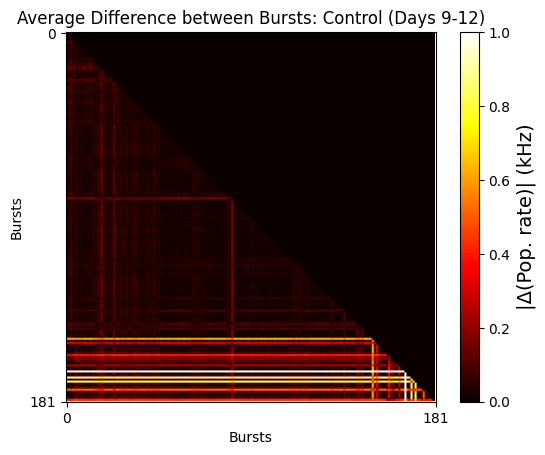

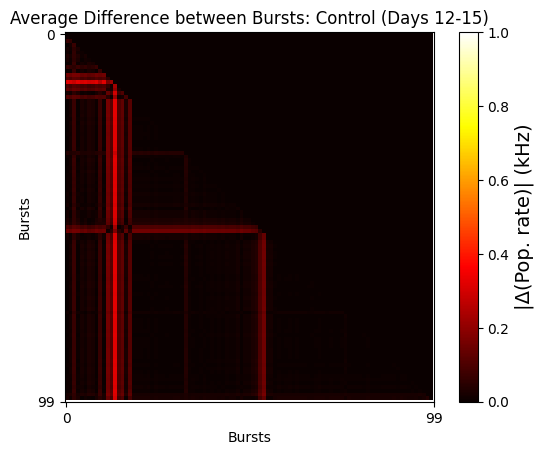

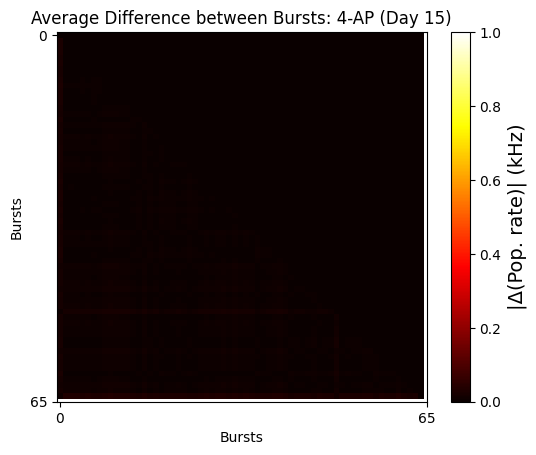

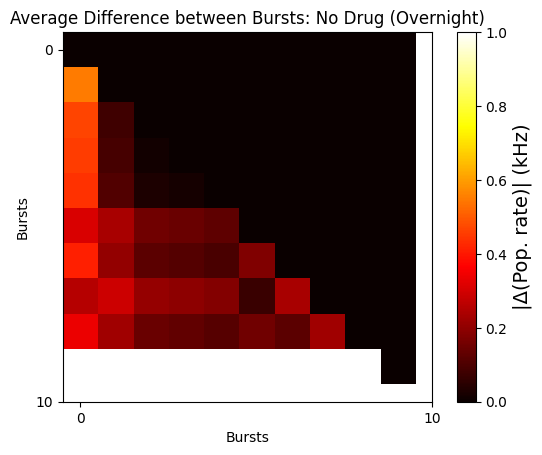

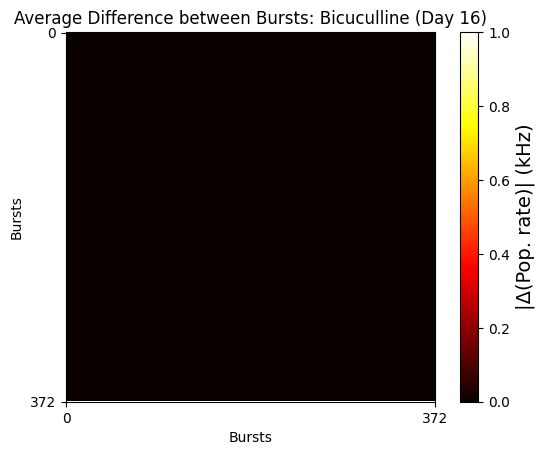

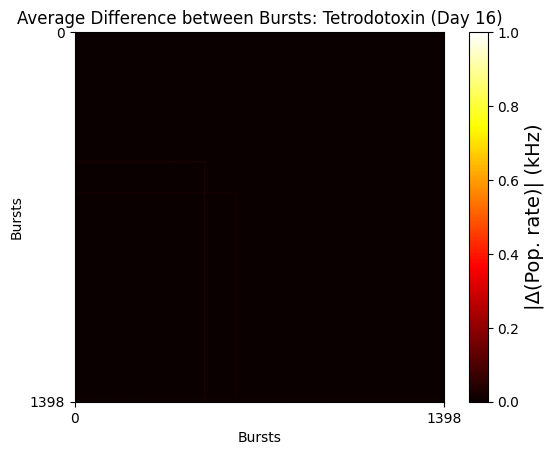

In [ ]:
# Plot average difference between bursts
for title, data in data_dict.items():

    diff_matrix = data["burst difference matrix"]
    num_bursts = diff_matrix.shape[0]

    plt.figure()

    plt.imshow(diff_matrix, cmap="hot", vmax=1)
    plt.title(f"Average Difference between Bursts: {title}")
    plt.xlabel("Bursts")
    plt.xticks([0, num_bursts])
    plt.ylabel("Bursts")
    plt.yticks([0, num_bursts])
    cbar = plt.colorbar()
    cbar.set_label("|\u0394(Pop. rate)| (kHz)", fontsize=14)

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_13048\1685127516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(data_dict.keys()), rotation=45, fontsize=6)


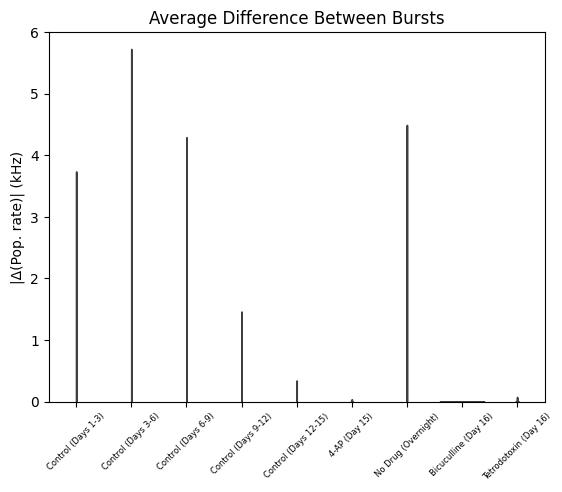

In [ ]:
# Plot average difference between bursts

df = pd.concat([
    pd.DataFrame({'Session': [k] * len(v["burst difference matrix"].flatten()), 'Data': v["burst difference matrix"].flatten()})
    for k, v in data_dict.items()
])

fig, ax = plt.subplots(1, 1)

# plot isi info
sns.violinplot(data=df, x='Session', y='Data', ax=ax, inner=None)
ax.set_title("Average Difference Between Bursts")
ax.set_ylabel("|\u0394(Pop. rate)| (kHz)")
ax.set_xlabel("")
ax.set_xticklabels(list(data_dict.keys()), rotation=45, fontsize=6)
ax.set_ylim([0, np.ceil(np.max(df.Data))])
plt.show()

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_13048\2073256051.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(list(data_dict.keys()))


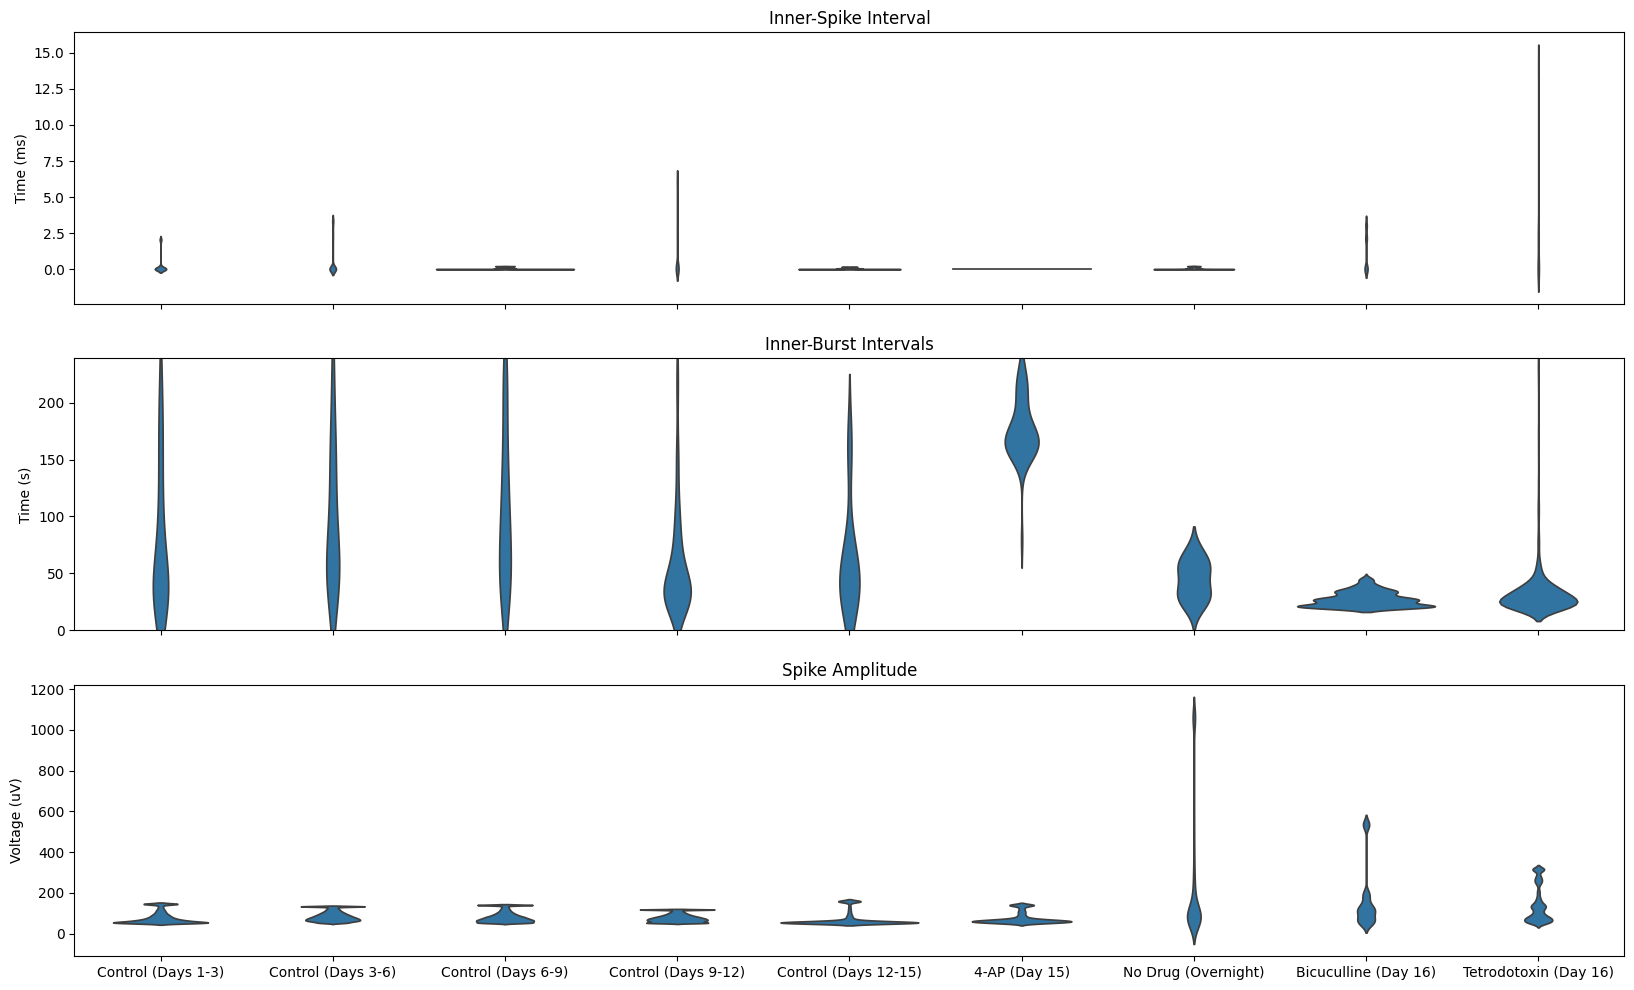

In [ ]:
# compare burst behavior between sessions (ISI, IBI, burst amplitude)
df_isi = pd.concat([
    pd.DataFrame({'Session': [k] * len(v["ISI"]), 'Data': np.minimum(v['ISI'], np.percentile(v['ISI'], 90))})
    for k, v in data_dict.items()
])

df_ibi = pd.concat([
    pd.DataFrame({'Session': [k] * np.sum(np.array(v["IBI"]) < 240), 'Data': np.array(v["IBI"])[np.array(v["IBI"]) < 240]})
    for k, v in data_dict.items()
])

df_Bamp = pd.concat([
    pd.DataFrame({'Session': [k] * len(v["burst amplitudes"]), 'Data':  np.minimum(v['burst amplitudes'], np.percentile(v['burst amplitudes'], 90)) / 1e3})
    for k, v in data_dict.items()
])

df_Samp = pd.concat([
    pd.DataFrame({'Session': [k] * len(v["spike amplitudes"]), 'Data': np.minimum(v['spike amplitudes'], np.percentile(v['spike amplitudes'], 90))})
    for k, v in data_dict.items()
])


fig, ax = plt.subplots(3, 1, figsize=(2+2*len(data_dict),12))

# plot isi info
sns.violinplot(data=df_isi, x='Session', y='Data', ax=ax[0], inner=None)
ax[0].set_title("Inner-Spike Interval")
ax[0].set_ylabel("Time (ms)")
ax[0].set_xlabel("")
ax[0].set_xticklabels([])

# plot ibi info
sns.violinplot(data=df_ibi, x='Session', y='Data', ax=ax[1], inner=None)
ax[1].set_title("Inner-Burst Intervals")
ax[1].set_ylabel("Time (s)")
ax[1].set_xlabel("")
ax[1].set_xticklabels([])
ax[1].set_ylim([0, np.ceil(np.max(df_ibi.Data))])

# plot burst amplitude info
# sns.violinplot(data=df_Bamp, x='Session', y='Data', ax=ax[2], inner=None)
# ax[2].set_title("Peak Burst Amplitude")
# ax[2].set_ylabel("Pop. Firing Rate (kHz)")
# ax[2].set_xlabel("")
# ax[2].set_xticklabels([])

# plot spike amplitude info
sns.violinplot(data=df_Samp, x='Session', y='Data', ax=ax[2], inner=None)
ax[2].set_title("Spike Amplitude")
ax[2].set_ylabel("Voltage (uV)")
ax[2].set_xlabel("")
ax[2].set_xticklabels(list(data_dict.keys()))

plt.show()

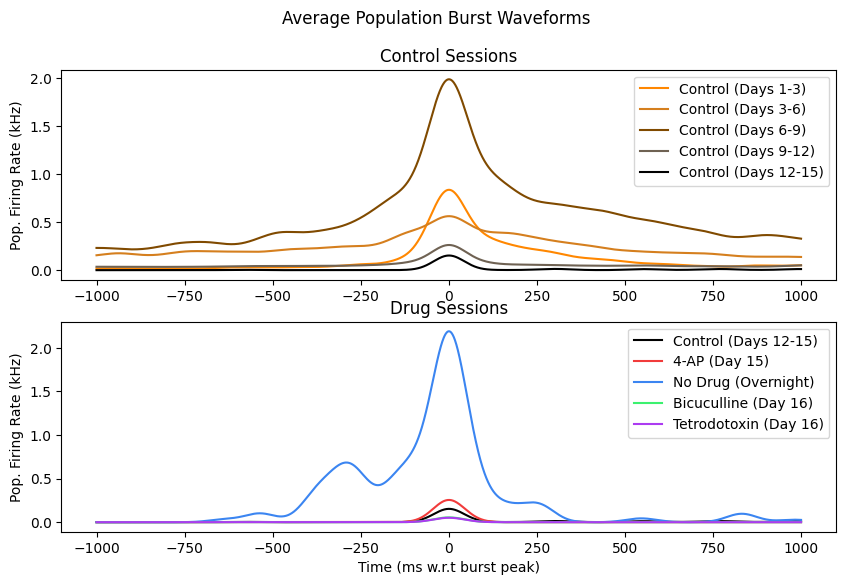

In [ ]:
# Compare burst waveforms across sessions

mean_we = []
for title, data in data_dict.items():

    burst_array = data["burst waveform array"]
    mean_burst_waveform = np.mean(burst_array, axis=0)
    mean_we.append(mean_burst_waveform)

t = np.arange(-t_endpoints[0], t_endpoints[1])
mean_we = np.array(mean_we).transpose()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.suptitle("Average Population Burst Waveforms")

colors = ["#ff8700", "#d57f1e", "#804a00", "#6f6253", "#000000", "#f13b3b", "#3b85f1", "#3bf16f", "#ac3bf1"]

for i in range(5):
    ax[0].plot(t, mean_we[:,i], color=colors[i], label=session_titles[i])
ax[0].set_ylabel("Pop. Firing Rate (kHz)")
ax[0].set_title("Control Sessions")
ax[0].legend()
for i in range(4, len(data_dict)):
    ax[1].plot(t, mean_we[:,i], color=colors[i], label=session_titles[i])
ax[1].set_ylabel("Pop. Firing Rate (kHz)")
ax[1].set_xlabel("Time (ms w.r.t burst peak)")
ax[1].set_title("Drug Sessions")
ax[1].legend()


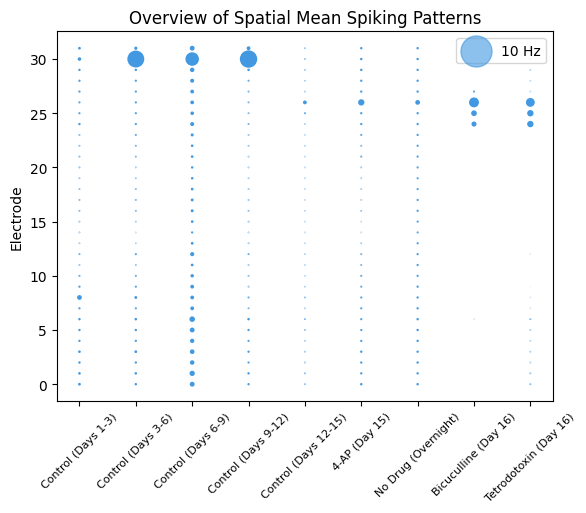

In [ ]:
# Visualize MUA Firing Rate Across Electrodes
# Get Data
fr_dict = {}
for title, restrictions in session_dict.items():

    channel_idxes, firing_rates = (mua.MUASpikes.Channel & restrictions).fetch("channel_idx", "spike_rate")
    fr_dict[title] = np.array([np.mean(firing_rates[channel_idxes==chan]) for chan in range(len(np.unique(channel_idxes)))])

plt.figure()

for i, (title, data) in enumerate(fr_dict.items()):
    y = np.arange(len(data))
    plt.scatter([i]*len(data), y, s=data*1e2, c="#4299e1")
plt.title("Overview of Spatial Mean Spiking Patterns")
plt.ylabel("Electrode")
plt.xticks(ticks=np.arange(len(session_titles)), labels=session_titles, rotation=45, fontsize=8)

plt.scatter([], [], s=5*1e2, c="#4299e1", alpha=0.6, label=f'10 Hz')
plt.legend(loc="upper right")
plt.show()